In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import re

from tqdm.notebook import tqdm

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer

from itertools import chain
from gensim.models import Word2Vec

import spacy
from spacy import displacy
from spacy.matcher import Matcher
from spacy.tokens import Span
nlp = spacy.load('en_core_web_sm')

from transformers import pipeline

import torch
from torch.nn import Conv1d, Linear, CrossEntropyLoss, RNN, BatchNorm1d
from torch.optim import Adam

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


####info

https://www.elibrary.ru/item.asp?id=48246639
<br>
https://www.kaggle.com/code/nageshsingh/build-knowledge-graph-using-python
<br>
https://www.kaggle.com/search?q=dataset+for+knowledge+graph+datasetSize%3Asmall
<br>
https://encord.com/blog/embeddings-machine-learning/#:~:text=In%20artificial%20intelligence%2C%20an%20embedding,learning%20algorithms%20can%20easily%20process
<br>
статья
*Universal Representation Learning of Knowledge Bases by
Jointly Embedding Instances and Ontological Concepts*
Junheng Hao, Muhao Chen, Wenchao Yu, Yizhou Sun, Wei Wang

##07 Создание базы знаний


###1\. Построить базу знаний в любой предметной области, сформировав массив документов и построить граф знаний об этих документах

(например, публикаций или файлов на каком-либо портале или набор файлов на компьютере или сервере и т.п.)
<br>
https://www.kaggle.com/datasets/pariza/bbc-news-summary/data
<br>
https://www.kaggle.com/code/saya2003/text-summarization

In [2]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""  # dependency tag of previous token in the sentence
    prv_tok_text = ""  # previous token in the sentence

    prefix = ""
    modifier = ""

    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""

                ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text

            ## chunk 5  # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text

    return [ent1.strip(), ent2.strip()]

In [4]:
def get_relation(sent):

    doc = nlp(sent)
    matcher = Matcher(nlp.vocab) # Matcher class object

    #define the pattern
    pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},
            {'POS':'ADJ','OP':"?"}]

    matcher.add("matching_1", [pattern])
    matches = matcher(doc)
    k = len(matches) - 1
    span = doc[matches[k][1]:matches[k][2]]

    return (span.text)

In [2]:
entities = []
relations = []

def read_article(text):
    sentences = sent_tokenize(text)
    new_sentences = []
    for sentence in sentences:
        s = sentence.replace("[^a-zA-Z0-9]", " ")
        s = s.replace("\n", " ")
        new_sentences.append(s)
        # entities.append(get_entities(sentence))
        # relations.append(get_relation(sentence))
    return " ".join(new_sentences)

In [47]:
path_, filename_, category_, text_ = [], [], [], []

for dirname, _, filenames in os.walk(f'/content/drive/MyDrive/Colab_Notebooks/МОвСиСА/data/Summaries'):
    for filename in tqdm(filenames[:100]):
        p = os.path.join(dirname, filename)
        path_.append(p)
        filename_.append(filename)
        category_.append(dirname.split("/")[-1])
        try:
            t = open(p, 'r').read()
        except UnicodeDecodeError as e:
            print(dirname, filename)
            print(e)
        text_.append(read_article(t.lower()))

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [48]:
df = pd.DataFrame({"path": path_, "filename": filename_, "category": category_, "text": text_},
                  columns=["path", "filename", "category", "text"])
df.head()

,path,filename,category,text
0,/content/drive/MyDrive/Colab_Notebooks/МОвСиСА...,005.txt,politics,"but mr balls, a prospective labour mp, said he..."
1,/content/drive/MyDrive/Colab_Notebooks/МОвСиСА...,003.txt,politics,ms hewitt also announced a new drive to help w...
2,/content/drive/MyDrive/Colab_Notebooks/МОвСиСА...,008.txt,politics,but she said there was a difference between th...
3,/content/drive/MyDrive/Colab_Notebooks/МОвСиСА...,002.txt,politics,all e-mails are subject to the freedom of info...
4,/content/drive/MyDrive/Colab_Notebooks/МОвСиСА...,007.txt,politics,mr blair said that whether the public chose mi...


In [11]:
read_article(df['text'][0])

'boeing unveils new 777 aircraft  us aircraft firm boeing has unveiled its new long-distance 777 plane, as it tries to regain its position as the industry\'s leading manufacturer. the 777-200lr will be capable of flying almost 11,000 miles non-stop, linking cities such as london and sydney. boeing, in contrast to european rival airbus, hopes airlines will want to fly smaller aircraft over longer distances. airbus, which overtook boeing as the number one civilian planemaker in 2003, is focusing on so-called super jumbos. analysts are divided over which approach is best and say that this latest tussle between boeing and airbus may prove to be a defining moment for the airline industry. boeing plans to offer twin-engine planes that are able to fly direct to many of the world\'s airports, getting rid of the need for connecting flights. it is banking on smaller, slimmer planes such as the 777-200lr and its much-anticipated 787 dreamliner plane, which is set to take to the skies in 2008. the

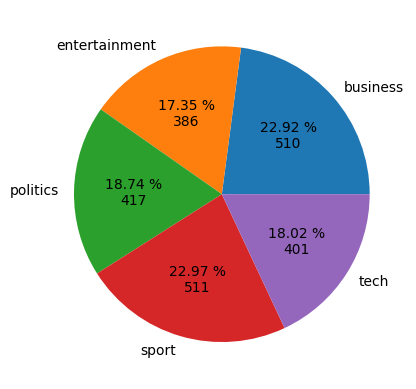

In [12]:
def cust_format(x):
    return f"{x:.2f} %\n{round(x * len(df) / 100)}"

d = df[['category', 'text']].groupby(['category']).count().to_dict()['text']
val = []
key = []
for k, v in d.items():
    key.append(k)
    val.append(v)
plt.pie(val, labels=key, autopct=cust_format)
plt.show()

In [13]:
source = [i[0] for i in entities] # extract subject
target = [i[1] for i in entities] # extract object

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df

,source,target,edge
0,distance 777 distance it,leading manufacturer,unveils new
1,777 200lr,such london,be capable
2,european rival airlines,longer distances,hopes
3,which,super jumbos,focusing on
4,latest tussle,defining airline industry,divided
...,...,...,...
40333,it,20 200lr years,said
40334,it,already pakistan international taiwan,has
40335,orders,profits,help
40336,earnings,smallest 767 tanker contract,said


In [14]:
pd.Series(relations).value_counts()[:20]

said        6129
is          1988
was          861
told         704
added        627
are          555
have         517
says         501
's           393
be           374
has          266
say          258
had          249
made         225
were         212
think        188
won          182
expected     180
been         173
set          162
Name: count, dtype: int64

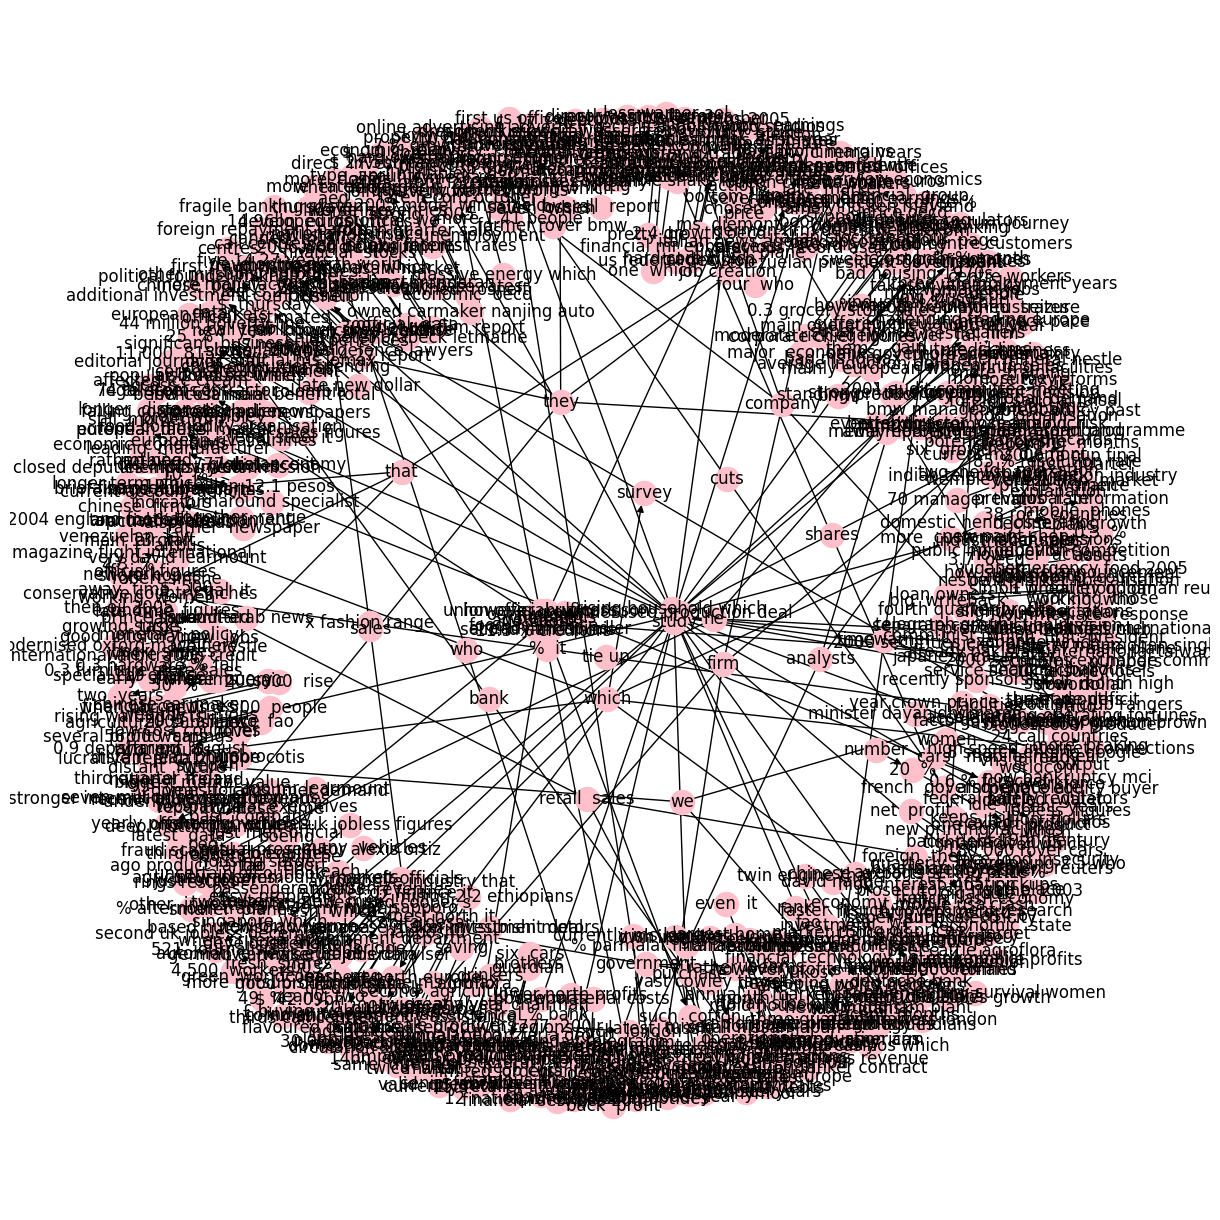

In [16]:
G = nx.from_pandas_edgelist(kg_df.iloc[:500], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='pink', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

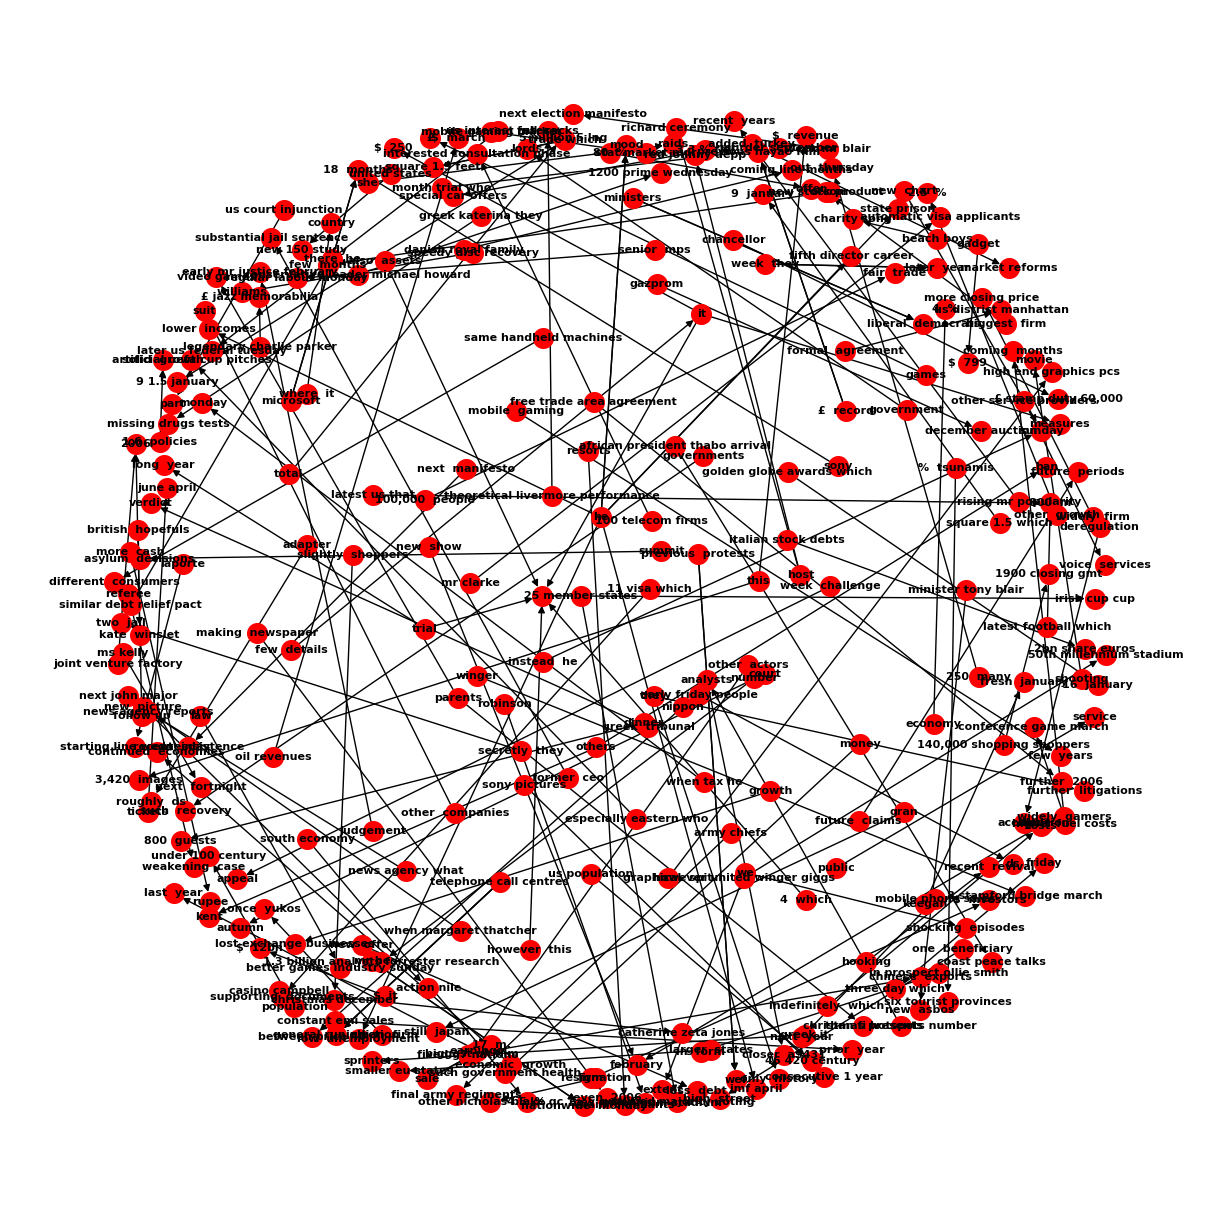

In [21]:
G = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="expected"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='red', font_size=8, node_size=200, edge_cmap=plt.cm.Blues, pos = pos, font_weight='bold')
plt.show()

###2\. Реализовать сервис краткого описания каждого документа в базе знаний (summary)

In [23]:
df['path'][0]

'/content/drive/MyDrive/Colab_Notebooks/МОвСиСА/data/News Articles/business/069.txt'

In [33]:
summarizer = pipeline("summarization", model='facebook/bart-large-cnn', min_length=1000)
hypothesis = summarizer(df['text'][0])[0]['summary_text']
# reference = df['text'][0]
reference = open('/content/drive/MyDrive/Colab_Notebooks/МОвСиСА/data/Summaries/business/069.txt', 'r').read()

BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(f"BLEUscore : {BLEUscore}\n")

Your min_length=1000 must be inferior than your max_length=142.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1192: UserWarning: Unfeasible length constraints: `min_length` (1000) is larger than the maximum possible length (142). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length. Note that `max_length` is set to 142, its default value.
  warnings.warn(


BLEUscore : 0.22333932321592614



In [31]:
reference

'Both Boeing and Airbus have been taking orders for their new planes.Boeing said it expected to sell about 500 of its 777-200LR planes over the next 20 years."Airbus is now where Boeing was a few years ago" with its product range, said Flight International\'s Mr Learmount.US aircraft firm Boeing has unveiled its new long-distance 777 plane, as it tries to regain its position as the industry\'s leading manufacturer.Boeing, in contrast to European rival Airbus, hopes airlines will want to fly smaller aircraft over longer distances.It is banking on smaller, slimmer planes such as the 777-200LR and its much-anticipated 787 Dreamliner plane, which is set to take to the skies in 2008."Boeing has the latest variant in a very successful line of airplanes and there is no doubt it will continue to be very successful," said David Learmount, operations and safety editor at industry magazine Flight International.Boeing plans to offer twin-engine planes that are able to fly direct to many of the wor

In [34]:
hypothesis

' us aircraft firm boeing unveils new long-distance 777 plane. 777-200lr will be capable of flying almost 11,000 miles non-stop. Boeing hopes airlines will want to fly smaller aircraft over longer distances. airbus is focusing on so-called super jumbos. analysts divided over which approach is best and say this tussle may prove to be a defining moment for the airline industry, says flight international\'s mr learmount. The company offically "rolled-out" the new 777 in seattle at 2200 gmt. better fuel efficiency from engines made by ge and lighter materials mean that the plane can connect almost any two cities worldwide'

###3\. Реализовать сервис поиска по запросу внутри базы знаний

In [131]:
def find_me(word, ps):
    stemmer = lambda text: [ps.stem(w) for w in word_tokenize(text)]
    stems = df['text'].apply(stemmer)

    res = []
    for idx_list_pair in stems.items():
        if word in idx_list_pair[1]:
            res.append(idx_list_pair[0])
    # finder = lambda list_: stems.index(list_) if word in list_ else None
    # i = stems.apply(finder)
    print(f'word found in files : \n')

    for i in res:
        print(f"with index {i} file {df['filename'][i]} from {df['category'][i]}")

    return res

ps = PorterStemmer()

res = find_me("while", ps)

word found in files : 

with index 0 file 019.txt from tech
with index 16 file 009.txt from tech
with index 29 file 070.txt from tech
with index 34 file 057.txt from tech
with index 46 file 048.txt from tech
with index 96 file 111.txt from tech
with index 99 file 112.txt from tech
with index 111 file 098.txt from tech
with index 121 file 092.txt from tech
with index 123 file 104.txt from tech
with index 137 file 188.txt from tech
with index 141 file 187.txt from tech
with index 152 file 185.txt from tech
with index 168 file 161.txt from tech
with index 171 file 162.txt from tech
with index 172 file 165.txt from tech
with index 176 file 149.txt from tech
with index 178 file 153.txt from tech
with index 180 file 166.txt from tech
with index 181 file 155.txt from tech
with index 197 file 209.txt from tech
with index 207 file 198.txt from tech
with index 219 file 237.txt from tech
with index 220 file 238.txt from tech
with index 221 file 239.txt from tech
with index 230 file 232.txt from t

##08 Использование базы знаний

###1\. Сформировать или скачать семантический граф

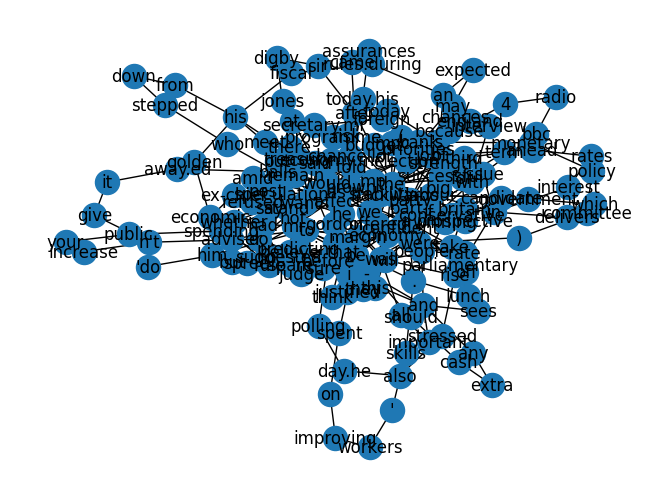

In [59]:
g = nx.Graph()
nx.add_path(g, word_tokenize(df['text'][0]))
nx.draw(g, with_labels=True)

In [50]:
sentences = df['text'].apply(word_tokenize).to_list()

short_sentences = [sentence[:512] if len(sentence) > 512 else sentence for sentence in sentences]

tokens = list(set(chain(*short_sentences)))

In [51]:
def get_sequences(tokens, size=5):
    sequences = []
    for i in range(len(tokens) - size + 1):
        sequences.append(tokens[i:i+size])
    return sequences

vec_model = Word2Vec(get_sequences(tokens), min_count=1, workers=4, vector_size=256)

embeds = [vec_model.wv[token] for token in short_sentences]

In [52]:
del sentences

In [53]:
embeddings = []
for e in embeds:
    # e = [vec_model.wv[token] for token in s]
    fill = np.zeros((512 - len(e), 256))
    e = np.append(e, fill, axis=0)
    embeddings.append(e)

In [54]:
le = LabelEncoder()
le.fit(df['category'].unique())
labels = torch.LongTensor(le.transform(df['category']))

In [55]:
emb = torch.Tensor(embeddings)

In [56]:
emb.shape

torch.Size([500, 512, 256])

In [57]:
X_train, X_test, y_train, y_test = train_test_split(emb, labels, test_size=0.2, random_state=42)

In [58]:
X_train.shape

torch.Size([400, 512, 256])

###2\. Реализовать модель GCN применительно к этому графу для классификации вершин графа

In [60]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes,
                 embed_dim=256, hid_dim=256, rnn_hid_dim=128):
        super(GCN, self).__init__()
        # self.gcn = GraphConv(num_features, embed_dim, allow_zero_in_degree=True)
        # self.bn1 = BatchNorm1d(num_features)
        # self.conv = Conv1d(in_channels=num_features, out_channels=hid_dim, kernel_size=3, padding=1)
        self.rnn = RNN(num_features, rnn_hid_dim, num_layers=3)
        self.fc_1 = Linear(rnn_hid_dim, 64)
        # self.fc_5 = Linear(128, 64)
        self.bn2 = BatchNorm1d(64)
        self.fc_2 = Linear(64, 32)
        self.bn3 = BatchNorm1d(32)
        self.fc_3 = Linear(32, 16)
        self.fc_4 = Linear(16, num_classes)
        self.emb = None

    def forward(self, feat):
        # self.emb = self.bn1(self.gcn(g, feat).relu())
        # emb = self.conv(feat.permute(1, 0)).relu()
        out, _ = self.rnn(feat) # self.emb.permute(1, 0)/unsqueeze(1)

        out = self.fc_1(out[:, -1, :]).relu()
        # out = self.fc_1(feat).relu()
        # out = self.fc_5(out).relu()
        out = self.bn2(out)
        out = self.fc_2(out).relu()
        out = self.bn3(out)
        out = self.fc_3(out).relu()
        out = self.fc_4(out)
        return out #.permute(1, 0), out

In [61]:
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

def train_me(num_epochs, model, feat, label, optimizer, criterion):
    losses = []

    for epoch in range(num_epochs+1):

        optimizer.zero_grad()
        out = model(feat)
        loss = criterion(out, label)
        losses.append(loss.detach().item())
        loss.backward()
        optimizer.step()

        acc = accuracy(out.argmax(dim=1), label)
        if epoch % 10 == 0:
            print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')
    return losses

In [62]:
lr = 0.15
num_epochs = 100

model = GCN(num_features=256, num_classes=5)
torch.nn.init.xavier_normal_(model.fc_1.weight)
torch.nn.init.xavier_normal_(model.fc_2.weight)
print(model)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses = train_me(num_epochs, model, X_train, y_train, optimizer, criterion)

GCN(
  (rnn): RNN(256, 128, num_layers=3)
  (fc_1): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_2): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_3): Linear(in_features=32, out_features=16, bias=True)
  (fc_4): Linear(in_features=16, out_features=5, bias=True)
)
Epoch   0 | Loss: 1.64 | Acc: 17.50%
Epoch  10 | Loss: 1.61 | Acc: 22.50%
Epoch  20 | Loss: 1.60 | Acc: 21.75%
Epoch  30 | Loss: 1.60 | Acc: 22.50%
Epoch  40 | Loss: 1.60 | Acc: 22.50%
Epoch  50 | Loss: 1.60 | Acc: 22.50%
Epoch  60 | Loss: 1.60 | Acc: 22.50%
Epoch  70 | Loss: 1.60 | Acc: 22.50%
Epoch  80 | Loss: 1.60 | Acc: 22.50%
Epoch  90 | Loss: 1.60 | Acc: 22.50%
Epoch 100 | Loss: 1.60 | Acc: 22.50%


<Axes: >

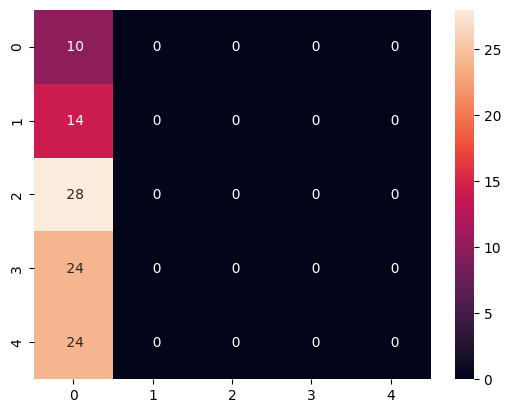

In [63]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test).argmax(dim=1)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='3.0f')

###3\. Сравнить качество полученной модели с другими моделями

0.225


<Axes: >

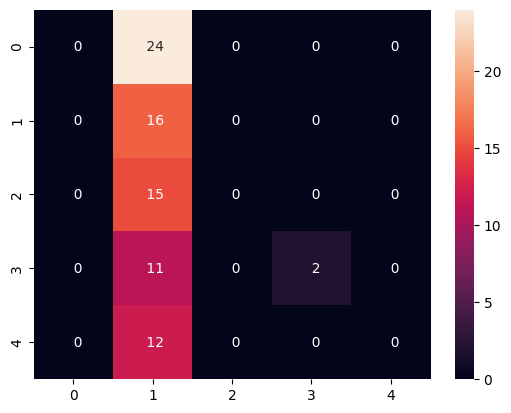

In [68]:
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

reg = LogisticRegression(max_iter=100).fit(torch.flatten(X_train, start_dim=1), y_train)
y_pred = reg.predict(torch.flatten(X_test, start_dim=1))
print(accuracy_score(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='3.0f')

0.1625


<Axes: >

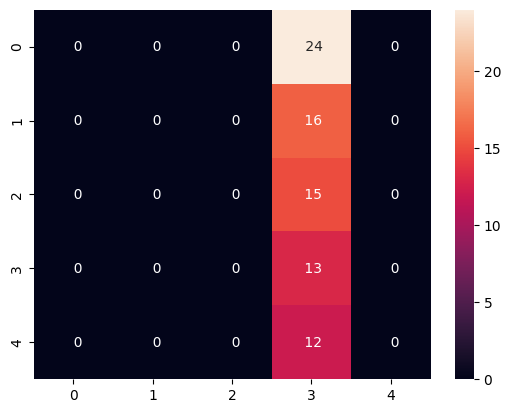

In [67]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3).fit(torch.flatten(X_train, start_dim=1), y_train)
y_pred_nei = neigh.predict(torch.flatten(X_test, start_dim=1))
print(accuracy_score(y_test, y_pred_nei))
sns.heatmap(confusion_matrix(y_test, y_pred_nei), annot=True, fmt='3.0f')